In [1]:
# From https://www.springboard.com/blog/beginners-guide-neural-network-in-python-scikit-learn-0-18/ 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, GridSearchCV
from sklearn.metrics import recall_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
import itertools
perform = pd.read_csv('../datasets/student_perform.csv')
perform.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


# Learning Curve Definition

In [2]:
# Courtesy of http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


# Confusion Matrix Definition

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Data

In [4]:
dicts = {}
for column in perform.columns:
    if perform[column].dtypes == object:
        perform[column], dicts[column] = pd.factorize(perform[column])
perform.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
gender,480.0,0.364583,0.481815,0.0,0.00,0.0,1.0,1.0
NationalITy,480.0,3.858333,3.848478,0.0,0.00,5.0,5.0,13.0
PlaceofBirth,480.0,3.510417,3.505423,0.0,0.00,4.5,5.0,13.0
StageID,480.0,0.654167,0.603732,0.0,0.00,1.0,1.0,2.0
GradeID,480.0,4.120833,3.560099,0.0,1.00,2.0,9.0,9.0
SectionID,480.0,0.472917,0.612411,0.0,0.00,0.0,1.0,2.0
Topic,480.0,4.402083,3.455472,0.0,2.00,4.0,7.0,11.0
Semester,480.0,0.489583,0.500413,0.0,0.00,0.0,1.0,1.0
Relation,480.0,0.410417,0.492423,0.0,0.00,0.0,1.0,1.0
raisedhands,480.0,46.775000,30.779223,0.0,15.75,50.0,75.0,100.0


In [5]:
X = perform.drop('Class', axis=1).values
y = perform['Class'].values

# Data Preprocessing

In [6]:
scaler = StandardScaler()

In [7]:
# Fit to training data
scaler.fit(X)
X = scaler.transform(X)

/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Train Test Split

In [8]:
# Apply the transformations to the data
X_train, X_test, y_train, y_test = train_test_split(X,y)

# Default Model

In [9]:
clf = MLPClassifier()
clf.fit(X_train, y_train)
print clf.score(X_test, y_test)

0.741666666667


/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Confusion matrix, without normalization
[[39  6  7]
 [ 4 28  1]
 [13  0 22]]


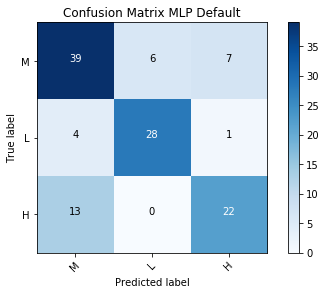

In [12]:
y_pred = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=dicts['Class'], title='Confusion Matrix MLP Default')
plt.show()
plt.clf()

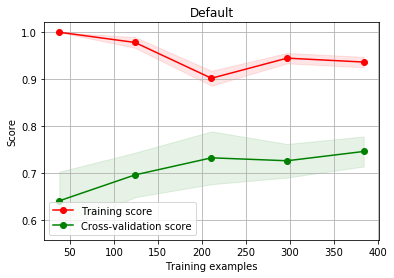

In [13]:
#     Plot learning curve
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
clf = MLPClassifier()

plot_learning_curve(clf, "Default", X, y, ylim=None, cv=cv, n_jobs=4).show()

## Perceptron

In [18]:
from sklearn.linear_model import Perceptron
clf = Perceptron()
clf.fit(X_train, y_train)
print clf.score(X_test, y_test)

0.658333333333


Confusion matrix, without normalization
[[29 10 13]
 [ 5 28  0]
 [13  0 22]]


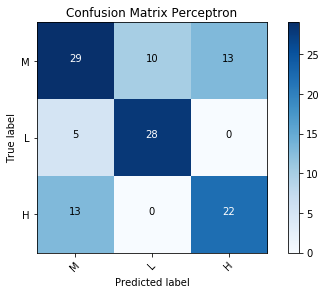

In [19]:
y_pred = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=dicts['Class'], title='Confusion Matrix Perceptron')
plt.show()
plt.clf()

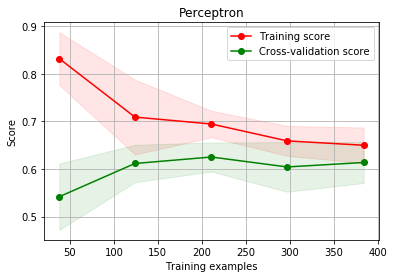

In [20]:
#     Plot learning curve
clf = Perceptron()

plot_learning_curve(clf, "Perceptron", X, y, ylim=None, cv=cv, n_jobs=4).show()

# Grid Search LBFGS

In [ ]:
%%capture output
# Set the parameters by cross-validation
tuned_parameters = [{'hidden_layer_sizes': [(13, 13, 13), (13, 13, 13, 13, 13, 13, 13, 13, 13, 13)], 
                     'activation': ['identity', 'logistic', 'tanh', 'relu'],
                     'alpha': [1e-2, 1e-3, 1e-4],
                     'max_iter': [400, 800]}]

scores = ['accuracy', 'precision_macro', 'recall_macro']

lbfgs_clf = []

for score in scores:
    plt.clf()
    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(MLPClassifier(solver='lbfgs', early_stopping=True), tuned_parameters, cv=5, verbose=0, scoring=score, n_jobs=4)
    clf.fit(X, y)

    plot_learning_curve(clf, scores[1], X, y, ylim=None, cv=cv, n_jobs=4).show()

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print

    print("Detailed classification report:")
    print
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print
    y_true, y_pred = y, clf.predict(X)
    print(classification_report(y_true, y_pred))
    print
    lbfgs_clf.append(clf)


# Grid Search SGD

In [ ]:
tuned_parameters = [{'hidden_layer_sizes': [(13, 13, 13), (13, 13, 13, 13, 13, 13, 13, 13, 13, 13)], 
                     'activation': ['identity', 'logistic', 'tanh', 'relu'],
                     'learning_rate': ['constant', 'invscaling', 'adaptive'],
                     'learning_rate_init': [1 ,1e-1, 1e-2, 1e-3],
                     'max_iter': [400, 800]}]

sgd_clf = []

for score in scores:
    plt.clf()
    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(MLPClassifier(solver='sgd', early_stopping=True, shuffle=True), tuned_parameters, cv=5, verbose=0, scoring=score, n_jobs=4)
    clf.fit(X, y)

    plot_learning_curve(clf, scores[1], X, y, ylim=None, cv=cv, n_jobs=4).show()

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print

    print("Detailed classification report:")
    print
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print
    y_true, y_pred = y, clf.predict(X)
    print(classification_report(y_true, y_pred))
    print
    sgd_clf.append(clf)


# Grid Search Adam

In [ ]:
tuned_parameters = [{'hidden_layer_sizes': [(13, 13, 13), (13, 13, 13, 13, 13, 13, 13, 13, 13, 13)], 
                     'activation': ['identity', 'logistic', 'tanh', 'relu'],
                     'learning_rate_init': [1 ,1e-1, 1e-2, 1e-3],
                     'max_iter': [400, 800]}]

adam_clf = []

for score in scores:
    plt.clf()
    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(MLPClassifier(solver='adam', early_stopping=True, shuffle=True), tuned_parameters, cv=5, verbose=0, scoring=score, n_jobs=4)
    clf.fit(X, y)

    plot_learning_curve(clf, scores[1], X, y, ylim=None, cv=cv, n_jobs=4).show()

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print

    print("Detailed classification report:")
    print
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print
    y_true, y_pred = y, clf.predict(X)
    print(classification_report(y_true, y_pred))
    print
    adam_clf.append(clf)


In [ ]:
capture.output()